# CMIP6 Negative values

**Following steps are included in this script:**

1. Load netCDF files
2. Remove not logic negative values
3. Save and replace netcdf files

In [22]:
# ========== Packages ==========
import sys
import os
import xarray as xr
import dask
from dask.diagnostics import ProgressBar
import importlib
import copy
import numpy as np

# Define the full path to the data_handling directory and the config file
data_handling_dir = '/work/ch0636/g300115/phd_project/common/src/data_handling'
config_dir = '/work/ch0636/g300115/phd_project/common/src'

# Add the directories to sys.path
sys.path.append(data_handling_dir)
sys.path.append(config_dir)

# Now import the functions from load_preprocessed_data.py and config
import load_data as ld
import save_data_as_nc as sd
from config import BASE_DIR, DEFAULT_MODEL, DEFAULT_VARIABLE, DEFAULT_TEMPORAL_RES, DEFAULT_EXPERIMENT

### Functions

In [23]:
def check_positive_negative_values(ds_dict):
    """
    Check for positive and negative values in each dataset within the dictionary.

    Parameters:
    ds_dict (dict): Dictionary of datasets, each containing various climate variables.

    Returns:
    None: Prints statements indicating variables with positive and negative values and their counts.
    """
    for name, ds in ds_dict.items():
        print(f"Checking positive and negative values for model: {name}")
        for var_name in ds.data_vars:
            negative_values = ds[var_name].where(ds[var_name] < 0).count().item()
            positive_values = ds[var_name].where(ds[var_name] > 0).count().item()

            if negative_values > 0:
                print(f"- {var_name}: {negative_values}")
            else:
                print(f"- {var_name}: 0")

            if positive_values > 0:
                print(f"+ {var_name}: {positive_values}")
            else:
                print(f"+ {var_name}: 0")

            if negative_values > positive_values:
                print(f"WARNING: Variable '{var_name}' has more negative ({negative_values}) than positive ({positive_values}) values in model '{name}'.")
                
        print("\n")

In [28]:
def correct_variable_sign(ds_dict, model_name, var_name):
    """
    Correct the sign of the specified variable for a specific model.

    Parameters:
    ds_dict (dict): Dictionary of datasets, each containing various climate variables.
    model_name (str): The name of the model to correct.
    var_name (str): The name of the variable to correct.

    Returns:
    dict: Updated dictionary with corrected sign for the specified variable.
    """
    ds_dict_copy = copy.deepcopy(ds_dict)

    if model_name not in ds_dict_copy:
        print(f"Model '{model_name}' not found in the dataset dictionary.")
        return ds_dict_copy

    ds = ds_dict_copy[model_name]

    if var_name not in ds:
        print(f"Variable '{var_name}' not found in model '{model_name}'.")
        return ds_dict_copy

    # Count positive and negative values before correction
    positive_values_before = ds[var_name].where(ds[var_name] > 0).count().item()
    negative_values_before = ds[var_name].where(ds[var_name] < 0).count().item()

    print(f"Before correction for model '{model_name}', variable '{var_name}':")
    print(f"Positive values: {positive_values_before}")
    print(f"Negative values: {negative_values_before}")

    # Correct the sign of the variable
    ds[var_name] = -ds[var_name]

    # Count positive and negative values after correction
    positive_values_after = ds[var_name].where(ds[var_name] > 0).count().item()
    negative_values_after = ds[var_name].where(ds[var_name] < 0).count().item()

    print(f"After correction for model '{model_name}', variable '{var_name}':")
    print(f"Positive values: {positive_values_after}")
    print(f"Negative values: {negative_values_after}")

    ds_dict_copy[model_name] = ds
    ds_dict_copy[model_name].attrs = ds.attrs

    return ds_dict_copy

In [25]:
def set_negative_values_to_zero(ds_dict):
    """
    Set all negative values to zero for all variables in each model in the dictionary.

    Parameters:
    ds_dict (dict): Dictionary of datasets, each containing various climate variables.

    Returns:
    dict: Updated dictionary with negative values set to zero.
    """
    ds_dict_copy = copy.deepcopy(ds_dict)
    
    for name, ds in ds_dict_copy.items():
        print(f"Processing model: {name}")
        for var_name in ds.data_vars:
            variable = ds[var_name]
            var_attrs = ds[var_name].attrs
            negative_values_before = variable.where(variable < 0).count().item()
            if negative_values_before > 0:
                print(f"Variable '{var_name}' has {negative_values_before} negative values in model '{name}'. Setting them to zero.")
                ds[var_name] = xr.where((variable < 0) & (~np.isnan(variable)), 0, variable)
                ds[var_name].attrs = var_attrs
                negative_values_after = ds[var_name].where(ds[var_name] < 0).count().item()
                print(f"Variable '{var_name}' now has {negative_values_after} negative values in model '{name}' after setting to zero.")
            else:
                print(f"Variable '{var_name}' has no negative values in model '{name}'.")
        print("\n")
    
    return ds_dict_copy

### 1. Load netCDF files

In [26]:
# ========= Define period, models and path ==============
data_state = 'processed'
data_product = 'CMIP6'
experiments = ['historical']
temp_res = 'month'
models = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GISS-E2-1-G', 'MIROC-ES2L', 'NorESM2-MM', 'UKESM1-0-LL', 'CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'MPI-ESM1-2-LR', 'TaiESM1']
variables=['evspsbl', 'tran', 'gpp', 'pr', 'lai', 'mrso', 'mrro'] 
           
# Execute load function with Dask
with ProgressBar():
    ds_dict = dask.compute(ld.load_multiple_models_and_experiments(BASE_DIR, data_state, data_product, experiments, temp_res, models, variables))[0]

No file found for variable 'gpp' in model 'CAMS-CSM1-0'.
Model 'CAMS-CSM1-0' is missing variables: gpp
[########################################] | 100% Completed | 64.18 s


['ssp370']


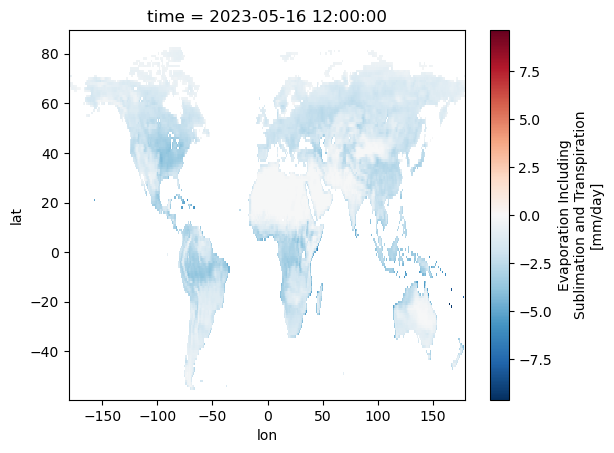

In [50]:
# ========= Have a look into the dictionary =======
print(list(ds_dict.keys()))
ds_dict[list(ds_dict.keys())[0]][models[1]][variables[0]].isel(time=100).plot()

### 2. Check and set negative values to 0

In [27]:
check_positive_negative_values(ds_dict[experiments[0]])

Checking positive and negative values for model: BCC-CSM2-MR
- evspsbl: 0
+ evspsbl: 29258174
- tran: 0
+ tran: 27162198
- gpp: 0
+ gpp: 25548029
- pr: 0
+ pr: 29894040
- lai: 0
+ lai: 28175400
- mrso: 0
+ mrso: 28668420
- mrro: 6019411
+ mrro: 22601523


Checking positive and negative values for model: CAMS-CSM1-0
- evspsbl: 0
+ evspsbl: 29371013
- tran: 9
+ tran: 24754925
- pr: 0
+ pr: 29894040
- lai: 0
+ lai: 27743309
- mrso: 0
+ mrso: 28121940
- mrro: 421
+ mrro: 27178495


Checking positive and negative values for model: CESM2-WACCM
- evspsbl: 0
+ evspsbl: 27620341
- tran: 0
+ tran: 27380693
- gpp: 0
+ gpp: 26390868
- pr: 0
+ pr: 29893681
- lai: 0
+ lai: 26515885
- mrso: 0
+ mrso: 28672380
- mrro: 3008955
+ mrro: 25218784


Checking positive and negative values for model: CNRM-ESM2-1
- evspsbl: 0
+ evspsbl: 29329467
- tran: 271
+ tran: 26574478
- gpp: 0
+ gpp: 26548238
- pr: 0
+ pr: 29894040
- lai: 0
+ lai: 29044992
- mrso: 0
+ mrso: 29551500
- mrro: 1913829
+ mrro: 27637671


Che

In [33]:
# Correct the sign for a variable in the specific model if needed
#updated_ds_dict = {}
#updated_ds_dict = correct_variable_sign(ds_dict[experiments[0]], 'CAMS-CSM1-0', 'evspsbl')

In [34]:
updated_ds_dict = {}
updated_ds_dict = set_negative_values_to_zero(ds_dict[experiments[0]])

Processing model: BCC-CSM2-MR
Variable 'evspsbl' has no negative values in model 'BCC-CSM2-MR'.
Variable 'tran' has no negative values in model 'BCC-CSM2-MR'.
Variable 'gpp' has no negative values in model 'BCC-CSM2-MR'.
Variable 'pr' has no negative values in model 'BCC-CSM2-MR'.
Variable 'lai' has no negative values in model 'BCC-CSM2-MR'.
Variable 'mrso' has no negative values in model 'BCC-CSM2-MR'.
Variable 'mrro' has 6019411 negative values in model 'BCC-CSM2-MR'. Setting them to zero.
Variable 'mrro' now has 0 negative values in model 'BCC-CSM2-MR' after setting to zero.


Processing model: CAMS-CSM1-0
Variable 'evspsbl' has no negative values in model 'CAMS-CSM1-0'.
Variable 'tran' has 9 negative values in model 'CAMS-CSM1-0'. Setting them to zero.
Variable 'tran' now has 0 negative values in model 'CAMS-CSM1-0' after setting to zero.
Variable 'pr' has no negative values in model 'CAMS-CSM1-0'.
Variable 'lai' has no negative values in model 'CAMS-CSM1-0'.
Variable 'mrso' has no

['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GISS-E2-1-G', 'MIROC-ES2L', 'NorESM2-MM', 'UKESM1-0-LL', 'CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'MPI-ESM1-2-LR', 'TaiESM1']


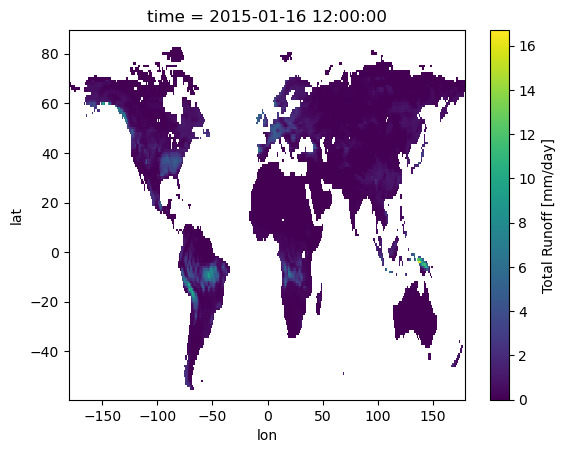

In [31]:
# ========= Have a look into the dictionary =======
print(list(updated_ds_dict.keys()))
updated_ds_dict[models[1]][variables[6]].isel(time=0).plot()

### 3. Save and replace netcdf files

In [35]:
# =========== Store file and remove any former one ==========
# Base directory
data_path = f'{data_state}/{data_product}/{experiments[0]}/{temp_res}/'
file_path = os.path.join(BASE_DIR, data_path)
print(file_path)

/work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/


In [36]:
sd.save_files(updated_ds_dict, file_path)

File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/evspsbl/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/evspsbl/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/tran/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/tran/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/gpp/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/gpp/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/pr/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/pr/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/lai/BCC-CSM2-MR.nc re